# Initial Machine Learning Studio setup 
https://github.com/MicrosoftLearning/mslearn-dp100/blob/main/06%20-%20Work%20with%20Data.ipynb

## Pull data from Blob to DataStore to DataSet

In [1]:
#import basic AzureML packages

import azureml.core
from azureml.core import Workspace, Datastore, Dataset


# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name)) 

Ready to use Azure ML 1.27.0 to work with geointerns_filter


In [2]:
# Get the current default datastore (if you just loaded the workspace this will not be the same as current example)
default_ds = ws.get_default_datastore()
print(default_ds)

{
  "name": "xview_datastore",
  "container_name": "xview",
  "account_name": "geointerns",
  "protocol": "https",
  "endpoint": "core.usgovcloudapi.net"
}


In [4]:
# Enumerate all datastores within the workspace, indicating which is the default
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == default_ds.name)

azureml_globaldatasets - Default = False
xview_datastore - Default = True
workspaceblobstore - Default = False
workspacefilestore - Default = False


In [5]:
#If you need to make a new datastore to connect to a Blob
storage_account_key = open(".storage_account_accesskey.txt", "r").read()
blob_datastore_name='xview_datastore' # Name of the datastore to workspace
container_name=os.getenv("BLOB_CONTAINER", "xview") # Name of Azure blob container
account_name=os.getenv("BLOB_ACCOUNTNAME", "geointerns") # Storage account name
account_key=os.getenv("BLOB_ACCOUNT_KEY", storage_Account_key) # Storage account access key

#register the containor to the workspace (aka store the connection information)
blob_datastore = Datastore.register_azure_blob_container(workspace=ws, 
                                                         datastore_name=blob_datastore_name, 
                                                         container_name=container_name, 
                                                         account_name=account_name,
                                                         account_key=account_key)

In [6]:
#set the newly created datastore as your default
ws.set_default_datastore('xview_datastore')

In [7]:
# Show the difference by displaying the current default datastore
default_ds = ws.get_default_datastore()
print(default_ds)

{
  "name": "xview_datastore",
  "container_name": "xview",
  "account_name": "geointerns",
  "protocol": "https",
  "endpoint": "core.usgovcloudapi.net"
}


In [8]:
#Check to see what datasets are inside
print("Datasets:")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name, 'version', dataset.version)

Datasets:
	 xview_train version 1
	 xview_val version 1


In [20]:
#Make the Datastore into a Dataset so it's accessible by Azure ML

#Create a file dataset from the path on the datastore (this may take a short while) (redo for training vs val)
blob_path = 'train_images/train_images/*.tif'
file_data_set = Dataset.File.from_files(path=(default_ds,blob_path))

# Get the files in the dataset
for file_path in file_data_set.to_path():
    print(file_path)

/10.tif
/100.tif
/102.tif
/1036.tif
/1037.tif
/104.tif
/1042.tif
/1044.tif
/1046.tif
/1048.tif
/1049.tif
/105.tif
/1050.tif
/1051.tif
/1052.tif
/1053.tif
/1056.tif
/1058.tif
/106.tif
/1061.tif
/1063.tif
/1065.tif
/1067.tif
/1068.tif
/107.tif
/1070.tif
/1072.tif
/1076.tif
/1077.tif
/1079.tif
/1080.tif
/1081.tif
/1084.tif
/1085.tif
/1086.tif
/1087.tif
/1088.tif
/1089.tif
/109.tif
/1090.tif
/1091.tif
/1092.tif
/1094.tif
/1095.tif
/110.tif
/1104.tif
/1106.tif
/1109.tif
/111.tif
/1114.tif
/1118.tif
/112.tif
/1120.tif
/1121.tif
/1124.tif
/1125.tif
/1126.tif
/1127.tif
/1128.tif
/1129.tif
/1132.tif
/1133.tif
/1135.tif
/1136.tif
/1139.tif
/1140.tif
/1141.tif
/1142.tif
/1149.tif
/1150.tif
/1154.tif
/1155.tif
/1158.tif
/1164.tif
/1165.tif
/1169.tif
/1175.tif
/1178.tif
/118.tif
/1180.tif
/1181.tif
/1182.tif
/1184.tif
/1185.tif
/1192.tif
/1193.tif
/1196.tif
/1197.tif
/1205.tif
/1206.tif
/1208.tif
/1211.tif
/1212.tif
/1216.tif
/1217.tif
/1224.tif
/1233.tif
/1237.tif
/124.tif
/1244.tif
/1245.tif
/124

In [21]:
#Register Dataset:

# Register the file dataset
try:
    file_data_set = file_data_set.register(workspace=ws,
                                            name='xview_train',
                                            description='training images from xview',
                                            tags = {'format':'tif'},
                                            create_new_version=True)
except Exception as ex:
    print(ex)

print('Datasets registered')

Datasets registered


In [22]:
#Show what datasets are inside now

print("Datasets:")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name, 'version', dataset.version)

Datasets:
	 xview_train version 1
	 xview_val version 1


## Once set up: How to load dataset for manipulation

In [3]:
from PIL import Image
import os

In [4]:
#make datafolder on compute instance

train_folder = os.path.join(os.getcwd(), 'data/train_xview')
val_folder = os.path.join(os.getcwd(), 'data/val_xview')

os.makedirs(train_folder, exist_ok = True)
os.makedirs(val_folder, exist_ok = True)


In [18]:
#download data from dataset into compute instance (can also mount instead of download)
train_dataset = ws.datasets['xview_train']
train_dataset.download(train_folder, overwrite=True)

val_dataset = ws.datasets['xview_val']
val_dataset.download(val_folder, overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/basic-4corecpu/code/Users/Jessica.Zhu/data/val_xview/1038.tif',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/basic-4corecpu/code/Users/Jessica.Zhu/data/val_xview/1040.tif',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/basic-4corecpu/code/Users/Jessica.Zhu/data/val_xview/1043.tif',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/basic-4corecpu/code/Users/Jessica.Zhu/data/val_xview/1054.tif',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/basic-4corecpu/code/Users/Jessica.Zhu/data/val_xview/1060.tif',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/basic-4corecpu/code/Users/Jessica.Zhu/data/val_xview/1062.tif',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/basic-4corecpu/code/Users/Jessica.Zhu/data/val_xview/1064.tif',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/basic-4corecpu/code/Users/Jessica.Zhu/data/val_xview/1066.tif',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/basic-4corecpu/code/Users/Jessica.Zhu/

In [15]:
#View random images (and continue doing ML like on a normal computer)
import random

file_list =  [x for x in os.listdir("data/train_xview")
               if os.path.isfile(os.path.join("data/train_xview", x))]


130.tif


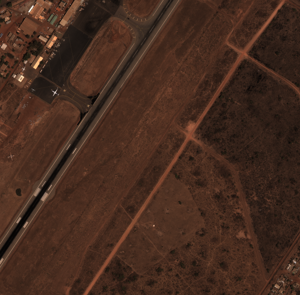

In [34]:
#display image
random.seed(28)
im_random = random.choice(file_list)  
print(im_random)
im = Image.open(fp="data/train_xview/"+im_random)
im.thumbnail((300,300)) #shrink it 
im.show()

##### Make sure to stop your compute instance. 

(The files will stay but the kernel and billing will stop)